In [ ]:
import os
from typing import Dict, Tuple

import numpy as np
import torch
from torch import nn
from torchvision import models as tvmodels
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_model = torch.cuda.get_device_name(torch.cuda.current_device())
print(f'GPU: {device_model}')

GPU: NVIDIA GeForce GTX 1080 Ti


In [ ]:
def set_seed(seed):
    """
    Function for setting the seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def warmup(model, dummy_in, warmup_steps=600, **_):
    dummy_in = dummy_in[None, :]
    for _ in range(warmup_steps):
        with torch.no_grad():
            model(dummy_in)


#Questions:
#- should I account for preprocessing time?
#- should I warmup every model? not really
def eval_model(model, dummy_inputs, use_grad=False, **kwargs):
    model.eval()
    warmup(model, dummy_inputs[0], **kwargs)

    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    records = np.zeros(len(dummy_inputs) - 1)

    with torch.set_grad_enabled(use_grad):
        for rep, dummy_input in enumerate(dummy_inputs[1:]):
            start_event.record()
            model(dummy_input[None, :])
            end_event.record()
            torch.cuda.synchronize()
            records[rep] = start_event.elapsed_time(end_event)
            
    return records


def num_params(model):
    return sum(int(np.prod(p.shape)) for p in model.parameters())


def eval_one_model(model_builder, weights, accuracy, dummy_inputs, **kwargs):
    model_name = model_builder.__name__
    print(f"Evaluating {model_name}")
    weights = weights.DEFAULT
    model = model_builder(weights=weights).to(device)
    times = eval_model(model, weights.transforms()(dummy_inputs), **kwargs)
    return {
        "name": model_name,
        "acc@1": accuracy,
        "num_params": num_params(model),
        "inference_mean": times.mean(),
    }


def show_models_comparison(
    df: pd.DataFrame,
    xvar: str,
    yvar: str,
    xlab: str,
    ylab: str,
    title: str,
    text_coords: Dict[str, Tuple[Tuple[float, float], str, str]] = None,
    yscale: str=None,
    fontsize=15,
    figsize=(10, 10),
    verbose=False
) -> Tuple[plt.Figure, plt.Axes]:
    fig, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(data=df, x=xvar, y=yvar, hue="name", ax=ax, legend=False, s=70)
    ax.set_xlabel(xlab, fontsize=fontsize)
    ax.set_ylabel(ylab, fontsize=fontsize)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_title(title, fontsize=fontsize)
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    if yscale:
        ax.set_yscale(yscale)
    ax.grid()
    text_coords = text_coords or {}
    for i, (_, row) in enumerate(df.iterrows()):
        coords, align_h, align_v = text_coords.get(row["name"], ((0.0, 12.0), "center", "baseline"))
        if verbose:
            print(row["name"], coords, align_h, align_v)
        ax.annotate(
            row["name"],
            xy=(row[xvar], row[yvar]),
            xytext=coords,
            horizontalalignment=align_h,
            verticalalignment=align_v,
            textcoords="offset points",
            fontsize=fontsize,
        )
    return fig, ax


def gen_synth_inputs(n=300) -> torch.Tensor:
    imagenet_shape = (n, 3, 224, 224)
    return torch.rand(*imagenet_shape)

In [ ]:
sns.set(style="ticks")

models = [
    tvmodels.vgg11,
    tvmodels.vgg11_bn,
    tvmodels.resnet18,
    tvmodels.resnet34,
    tvmodels.densenet121,
    tvmodels.mobilenet_v3_small,
]

pretrained_weights = [
    tvmodels.VGG11_Weights,
    tvmodels.VGG11_BN_Weights,
    tvmodels.ResNet18_Weights,
    tvmodels.ResNet34_Weights,
    tvmodels.DenseNet121_Weights,
    tvmodels.MobileNet_V3_Small_Weights,
]

accuracies = np.array([69.02, 70.37, 69.758, 73.314, 74.434, 67.668])
accuracies /= 100.0

In [ ]:
assets_dir = os.path.join(os.getcwd(), "assets")
os.makedirs(assets_dir, exist_ok=True)
print(f"All images saved to {assets_dir}")

All images saved to /home/lcur0339/uvadlc_practicals_2022/assignment2/part1/assets


In [ ]:
set_seed(42)

synth_inputs = gen_synth_inputs(n=301).to(device)
print(f"Synthetic inputs: {synth_inputs.shape} {synth_inputs.dtype}")

Synthetic inputs: torch.Size([301, 3, 224, 224]) torch.float32


In [ ]:
# NOTE I think warmup is to be done once, however do it every time here to have
# standardized comparisons
models_times = [
    eval_one_model(model_, weights, accuracy, synth_inputs, warmup_steps=warmup_steps)
    for model_, weights, accuracy, warmup_steps in zip(
        models, pretrained_weights, accuracies, [600] * len(models)
    )
]

Evaluating vgg11
Evaluating vgg11_bn
Evaluating resnet18
Evaluating resnet34
Evaluating densenet121
Evaluating mobilenet_v3_small


In [ ]:
models_times_df = pd.DataFrame(models_times)
models_times_df

,name,acc@1,num_params,inference_mean
0,vgg11,0.69020,132863336,4.491089
1,vgg11_bn,0.70370,132868840,4.772953
2,resnet18,0.69758,11689512,5.019737
3,resnet34,0.73314,21797672,8.617023
4,densenet121,0.74434,7978856,32.304563
5,mobilenet_v3_small,0.67668,2542856,10.096283


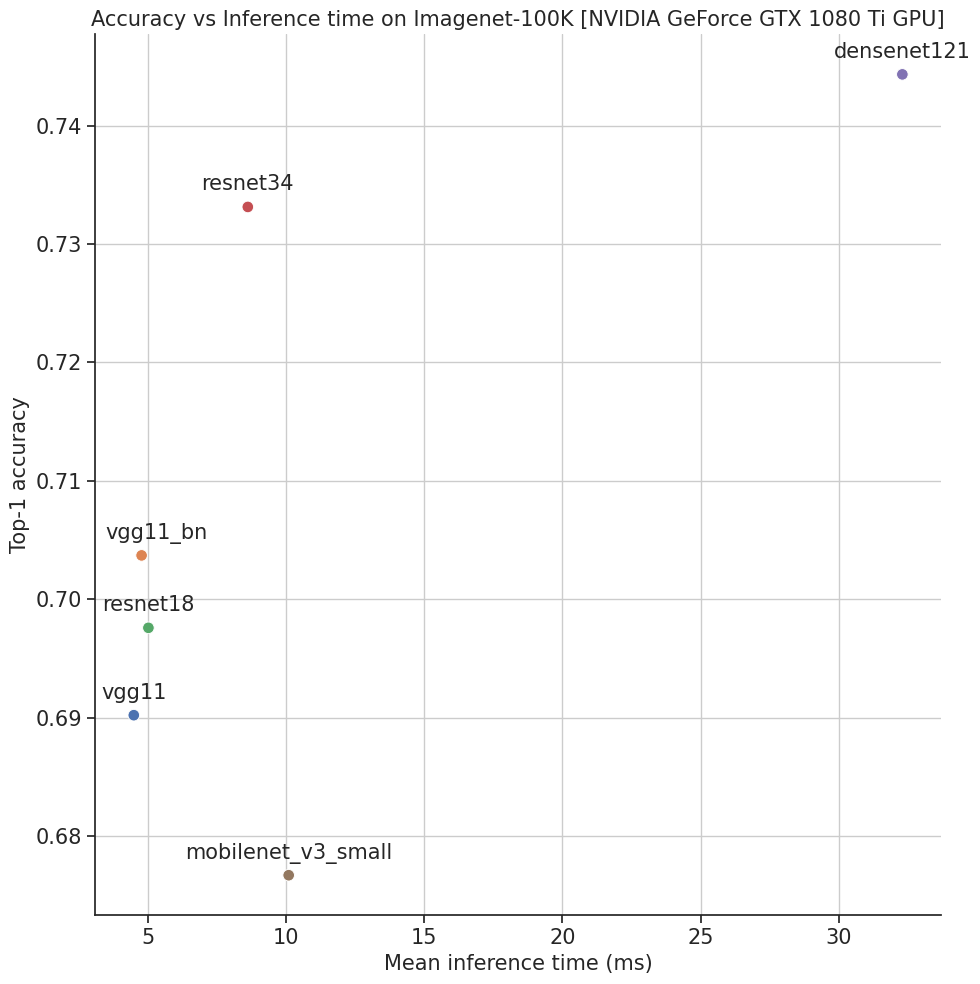

In [ ]:
fig, _ = show_models_comparison(
    models_times_df,
    "inference_mean",
    "acc@1",
    "Mean inference time (ms)",
    "Top-1 accuracy",
    f"Accuracy vs Inference time on Imagenet-100K [{device_model} GPU]",
    text_coords={"vgg11_bn": ((11.0, 12.0), "center", "baseline")},
)
plt.tight_layout()

In [ ]:
fname = os.path.join(assets_dir, f"accuracy_infer_speed_{device_model}.png")
fname = fname.replace(" ", "_")
fig.savefig(fname)
print(f"Saved image {fname}")

Saved image /home/lcur0339/uvadlc_practicals_2022/assignment2/part1/assets/accuracy_infer_speed_NVIDIA_GeForce_GTX_1080_Ti.png


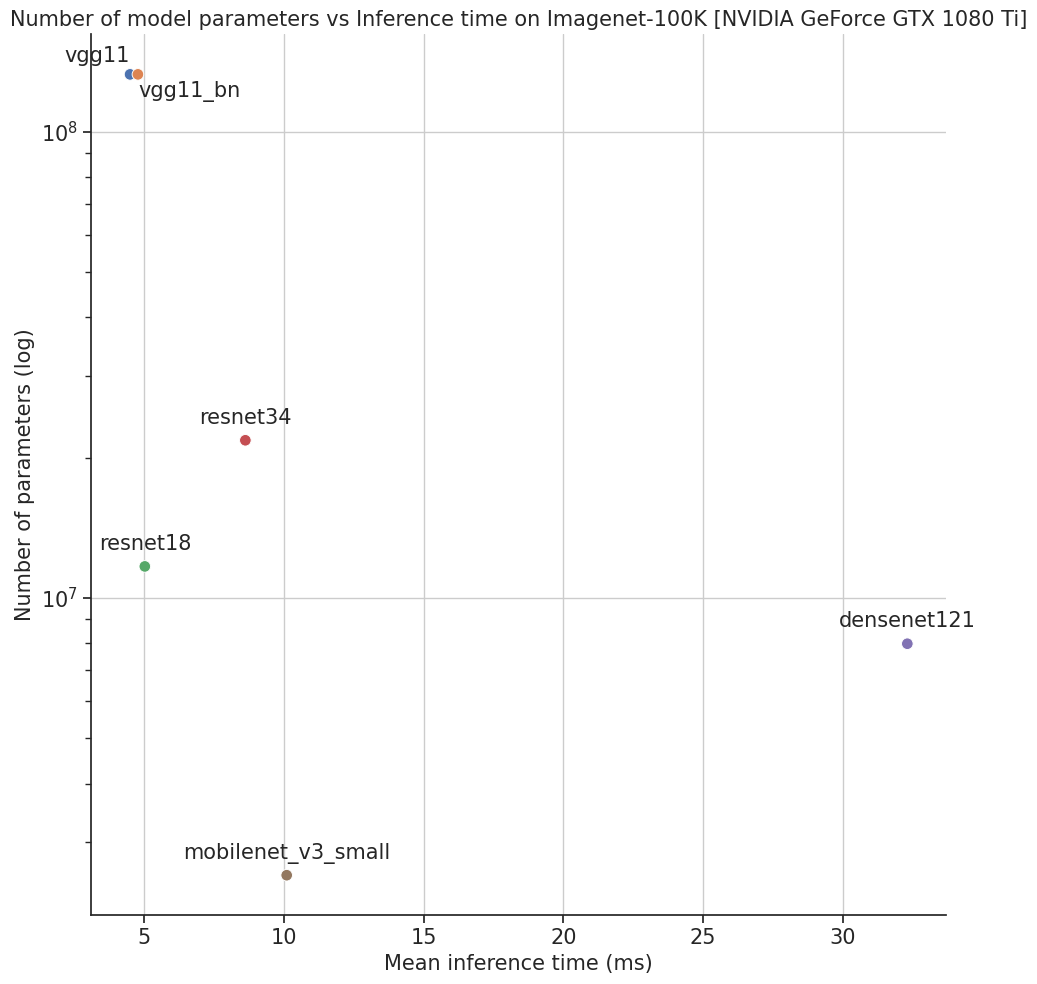

In [ ]:
fig, _ = show_models_comparison(
    models_times_df,
    "inference_mean",
    "num_params",
    "Mean inference time (ms)",
    "Number of parameters (log)",
    f"Number of model parameters vs Inference time on Imagenet-100K [{device_model}]",
    text_coords={
        #"resnet18": ((11.0, 13.0), "center", "baseline"),
        "vgg11": ((0.0, 9.0), "right", "baseline"),
        "vgg11_bn": ((0.0, -16.0), "left", "baseline"),
    },
    yscale="log"
)
plt.tight_layout()

In [ ]:
fname = os.path.join(assets_dir, f"numparams_infer_speed_{device_model}.png")
fname = fname.replace(" ", "_")
fig.savefig(fname)
print(f"Saved image {fname}")

Saved image /home/lcur0339/uvadlc_practicals_2022/assignment2/part1/assets/numparams_infer_speed_NVIDIA_GeForce_GTX_1080_Ti.png


In [ ]:
models_times_grad = [
    eval_one_model(
        model_, weights, accuracy, synth_inputs, warmup_steps=warmup_steps, use_grad=True
    )
    for model_, weights, accuracy, warmup_steps in zip(
        models, pretrained_weights, accuracies, [600] * len(models)
    )
]

Evaluating vgg11
Evaluating vgg11_bn
Evaluating resnet18
Evaluating resnet34
Evaluating densenet121
Evaluating mobilenet_v3_small


In [ ]:
times_grad_df = pd.DataFrame(models_times_grad)
times_grad_df["grad"] = True
times_grad_df

,name,acc@1,num_params,inference_mean,grad
0,vgg11,0.69020,132863336,4.445861,True
1,vgg11_bn,0.70370,132868840,4.763543,True
2,resnet18,0.69758,11689512,5.680632,True
3,resnet34,0.73314,21797672,9.666681,True
4,densenet121,0.74434,7978856,37.053672,True
5,mobilenet_v3_small,0.67668,2542856,12.312325,True


In [ ]:
models_times_df["grad"] = False
merged_df = pd.concat([models_times_df, times_grad_df])

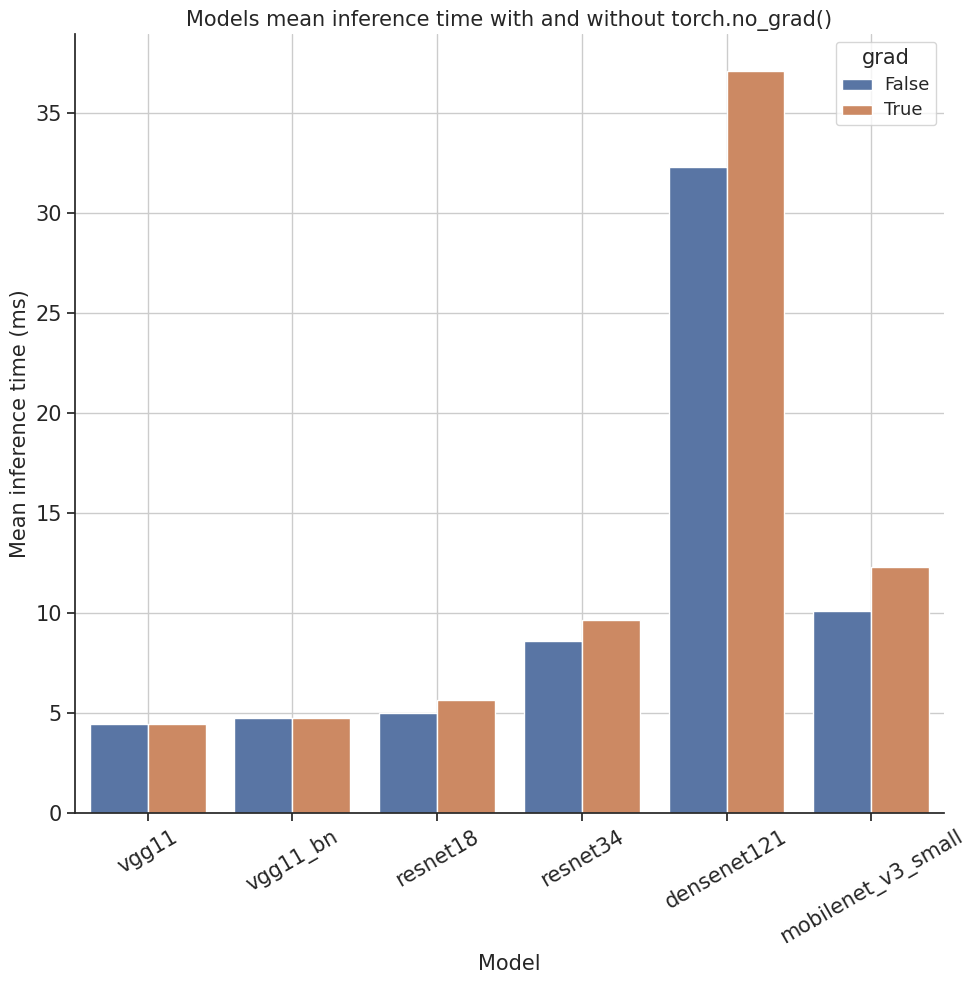

In [ ]:
figsize = (10, 10)
fontsize = 15

fig, ax = plt.subplots(figsize=figsize)
sns.barplot(data=merged_df, x="name", y="inference_mean", hue="grad", ax=ax)
ax.set_xlabel("Model", fontsize=fontsize)
ax.set_ylabel("Mean inference time (ms)", fontsize=fontsize)
ax.set_title("Models mean inference time with and without torch.no_grad()", fontsize=fontsize)
ax.xaxis.set_tick_params(labelsize=fontsize)
ax.yaxis.set_tick_params(labelsize=fontsize)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.setp(ax.get_legend().get_title(), fontsize=str(fontsize)) 
plt.setp(ax.get_legend().get_texts(), fontsize='13') 
ax.grid()
plt.tight_layout()

In [ ]:
fname = os.path.join(assets_dir, f"infer_speed_grad_comparison_{device_model}.png")
fname = fname.replace(" ", "_")
fig.savefig(fname)
print(f"Saved image {fname}")

Saved image /home/lcur0339/uvadlc_practicals_2022/assignment2/part1/assets/infer_speed_grad_comparison_NVIDIA_GeForce_GTX_1080_Ti.png
